In [ ]:
import rbm
import numpy as np
import projectLib as lib
import matplotlib.pyplot as plt
import inspect

In [ ]:
F=5
K=5

In [ ]:
training = lib.getTrainingData()
ratingsForUser1 = lib.getRatingsForUser(1, training)

In [ ]:
# ratingsPerMovie(training)
v = rbm.getV(ratingsForUser1)
# v.shape
w = rbm.getInitialWeights(v.shape[0],F,5)

In [ ]:
trStats = lib.getUsefulStats(training)
W = rbm.getInitialWeights(trStats["n_movies"], F, K)

In [ ]:
num_movies=trStats["n_movies"]
vis_bias=np.zeros((num_movies,5))
hid_bias=np.zeros((F,))

In [ ]:
h = [0,1,0,1,0]

In [ ]:
rbm.hiddenToVisible(h, W[ratingsForUser1[:, 0], :, :])
h = [0,1,0,1,0]

In [ ]:
rbm.getPredictedDistribution(v, W[ratingsForUser1[:, 0], :, :], W[1, :, :], vis_bias, hid_bias)

In [4]:
# %load mainrbm.py
import numpy as np
import rbm
import projectLib as lib
import matplotlib.pyplot as plt
import inspect

training = lib.getTrainingData()
validation = lib.getValidationData()
# You could also try with the chapter 4 data
# training = lib.getChapter4Data()

trStats = lib.getUsefulStats(training)
vlStats = lib.getUsefulStats(validation)

K = 5
alpha = 0.9

# SET PARAMETERS HERE!!!
# number of hidden units
F = 5
epochs = 30
gradientLearningRate = 0.0001
gradientLearningRate_v = 0.001
gradientLearningRate_h = 0.001
_lambda = 1
minibatch_size = 10

def adaptiveLearn(learning_rate_type=['constant','adapt','time', 'step', 'exponential'], 
                  lr=0.0001, k=0.1, epoch=None, drop=0.5, epochs_drop=10.0):
#time-based decay, step decay and exponential decay
    if learning_rate_type == 'constant':
        return lr
    elif learning_rate_type == 'adapt':
        return lr/(epoch**2)
    elif learning_rate_type == 'time':
        return lr/(1.0+k*epoch)
    elif learning_rate_type == 'step':
        return lr*np.power(drop,np.floor((1+epoch)/epochs_drop))
    elif learning_rate_type == 'exponential':
        return lr*np.exp(-k*epoch)
    
def batch_get(array, B):
    ret = []
    for i in range(int(len(array)/B)):
        ret.append(array[i*B:i*B+B])
    if len(array)%B != 0:
        ret.append(array[len(array)/B:])
    return ret

def main_rbm(training=training, validation=validation, trStats=trStats, vlStats=vlStats, 
             K=5, F=5, epochs=30, gradientLearningRate=0.0001,gradientLearningRate_v = 0.0001,
             gradientLearningRate_h = 0.0001, minibatch_size=10, alpha=0.9, 
             stopping=False, momentum=False, learning_rate_type='time', learning_rate_k=0.1, 
             learning_rate_drop=0.5, learning_rate_epochs_drop=10.0, _lambda = 0.3):
    
    # Print current hyperparams
#     frame = inspect.currentframe()
#     args, _, _, values = inspect.getargvalues(frame)
#     print ('Training and Predicting with the following hyperparameters:')
#     for i in args[4:]:
#         print ("    %s = %s" % (i, values[i]))
        
    # Initialise all our arrays
    num_movies=trStats["n_movies"]
    num_users=trStats["n_users"]
    W = rbm.getInitialWeights(trStats["n_movies"], F, K)
    posprods = np.zeros(W.shape)
    negprods = np.zeros(W.shape)
    grad_w = np.zeros(W.shape)
    m_w=np.zeros((W.shape[0],F,5))
    train_loss = []
    validation_loss = []
    vis_bias=np.zeros((num_movies,5))
    m_v=np.zeros((num_movies,5))
    hid_bias=np.zeros((F,))
    m_h=np.zeros((F,))
    best_train_loss = 100
    best_validation_loss = 100

    for epoch in range(1, epochs+1):
    #     mini_batch_grads = []
        # in each epoch, we'll visit all users in a random order
        visitingOrder = np.array(trStats["u_users"])
        np.random.shuffle(visitingOrder)
#         for i in range(0, visitingOrder.shape[0], minibatch_size):
#                 # Get pair of (X, y) of the current minibatch/chunk
#             visitingOrderMini = visitingOrder[i:i + minibatch_size]
#                 y_train_mini = y_train[i:i + minibatch_size]
#         for i in range(0, visitingOrder.shape[0], minibatch_size):
        batches = batch_get(visitingOrder, minibatch_size)
        poshidact,posvisact,neghidact,negvisact = 0,0,0,0
        for batch in batches:
            prev_grad = grad_w
            grad_w = np.zeros(W.shape)
            for user in batch:
                # get the ratings of that user
                ratingsForUser = lib.getRatingsForUser(user, training)

                # build the visible input
                v = rbm.getV(ratingsForUser)

                # get the weights associated to movies the user has seen
                weightsForUser = W[ratingsForUser[:, 0], :, :]

                ### LEARNING ###
                # propagate visible input to hidden units
                posHiddenProb = rbm.visibleToHiddenVec(v, weightsForUser,hid_bias) #, hid_bias)
                # get positive gradient
                # note that we only update the movies that this user has seen!
                posprods[ratingsForUser[:, 0], :, :] += rbm.probProduct(v, posHiddenProb)

                ### UNLEARNING ###
                # sample from hidden distribution
                sampledHidden = rbm.sample(posHiddenProb)
                # propagate back to get "negative data"
                negData = rbm.hiddenToVisible(sampledHidden, weightsForUser,vis_bias[ratingsForUser[:,0]])#, vis_bias[ratingsForUser[:,0]])
                # propagate negative data to hidden units
                negHiddenProb = rbm.visibleToHiddenVec(negData, weightsForUser,hid_bias) #, hid_bias)
                # get negative gradient
                # note that we only update the movies that this user has seen!
                negprods[ratingsForUser[:, 0], :, :] += rbm.probProduct(negData, negHiddenProb)

                poshidact += sum(posHiddenProb)
                posvisact += sum(v)
                neghidact += sum(negHiddenProb)
                negvisact += sum(negData)
                # we average over the number of users in the batch (if we use mini-batch)
    #             grad = (gradientLearningRate/epoch)*(posprods-negprods)
                '''
                Regularization - 
                '''
                grad_w += adaptiveLearn(learning_rate_type=learning_rate_type, k=learning_rate_k, 
                                        drop=learning_rate_drop, epochs_drop=learning_rate_epochs_drop, 
                                        epoch=epoch)*((posprods-negprods)/trStats["n_users"]-_lambda*W)
        #         mini_batch_grads.append(grad)

            #     m = alpha*m+grad
                '''
                Ask about the implementation of biases (should we create matrix of biases for hidden and visible layers?)
                '''
            m_w = alpha*m_w + grad_w
            m_v = alpha*m_v+(gradientLearningRate_v) * (posvisact - negvisact)
            m_h = alpha*m_h+(gradientLearningRate_h) * (poshidact - neghidact)

            if momentum == False:
                W += grad_w
            else:
                W += m_w

            vis_bias += m_v
            hid_bias += m_h

        # Print the current RMSE for training and validation sets
        # this allows you to control for overfitting e.g
        # We predict over the training set
        tr_r_hat = rbm.predict(trStats["movies"], trStats["users"], W, training,vis_bias,hid_bias) #, vis_bias, hid_bias, predictType='exp')
    #     print (tr_r_hat)
        trRMSE = lib.rmse(trStats["ratings"], tr_r_hat)
    #     print (trRMSE)
        if trRMSE < best_train_loss:
            best_train_loss = trRMSE
            best_training_weights = W
            best_train_predictions = tr_r_hat

        # We predict over the validation set
        vl_r_hat = rbm.predict(vlStats["movies"], vlStats["users"], W, training,vis_bias,hid_bias) #, vis_bias, hid_bias, predictType='exp')
    #     vl_r_hat
        vlRMSE = lib.rmse(vlStats["ratings"], vl_r_hat)
        if vlRMSE < best_validation_loss:
            best_validation_loss = vlRMSE
            best_validation_weights = W
            best_validation_predictions = vl_r_hat
            best_vis_bias = vis_bias
            best_hid_bias = hid_bias
#             best_momentum = momentum
#             best_reg = regularization
#             best_epoch = epoch
#             best_alpha = alpha
#             best_B = B
#             best_F = F
#             min_rmse = vlRMSE
#                     print('Best RMSE:', min_rmse)

        train_loss.append(trRMSE)
        validation_loss.append(vlRMSE)

        print ("### EPOCH %d ###" % epoch)
        print ("Training loss = %f" % trRMSE)
        print ("Validation loss = %f" % vlRMSE)

    ### END ###
    # This part you can write on your own
    # you could plot the evolution of the training and validation RMSEs for example
    # predictedRatings = np.array([predictForUser(user, W, training) for user in trStats["u_users"]])
    # np.savetxt("predictedRatings.txt", predictedRatings)
    # fig1 = plt.figure()
    # ax1 = fig1.add_subplot(121)
    # ax1.plot(train_loss)
    # ax2 = fig1.add_subplot(122)
    # ax2.plot(validation_loss)
    
    plt.plot(train_loss)
    plt.plot(validation_loss)
    plt.show()
    if stopping==True:
        print('Best training loss = %f' % best_train_loss)
        print('Best validation loss = %f' % best_validation_loss)
    else:
        print('Final training loss = %f' % trRMSE)
        print('Final validation loss = %f' % vlRMSE)
    return [best_validation_loss, best_validation_predictions, best_validation_weights, best_vis_bias, best_hid_bias]

### EPOCH 1 ###
Training loss = 1.212948
Validation loss = 1.237642
### EPOCH 2 ###
Training loss = 1.212118
Validation loss = 1.237540
### EPOCH 3 ###
Training loss = 1.211934
Validation loss = 1.236046
### EPOCH 4 ###
Training loss = 1.211350
Validation loss = 1.235989
### EPOCH 5 ###
Training loss = 1.210170
Validation loss = 1.234543
### EPOCH 6 ###
Training loss = 1.209901
Validation loss = 1.232846
### EPOCH 7 ###
Training loss = 1.209575
Validation loss = 1.233661
### EPOCH 8 ###
Training loss = 1.209530
Validation loss = 1.233047
### EPOCH 9 ###
Training loss = 1.208982
Validation loss = 1.232754
### EPOCH 10 ###
Training loss = 1.208381
Validation loss = 1.232253
### EPOCH 11 ###
Training loss = 1.207930
Validation loss = 1.232406
### EPOCH 12 ###
Training loss = 1.207668
Validation loss = 1.231578
### EPOCH 13 ###
Training loss = 1.207554
Validation loss = 1.232297
### EPOCH 14 ###
Training loss = 1.207176
Validation loss = 1.231020
### EPOCH 15 ###
Training loss = 1.206571
V

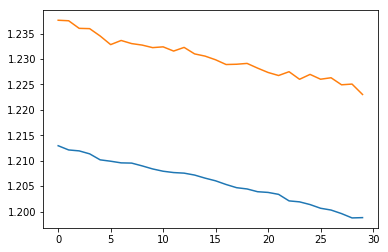

Best training loss = 1.198743
Best validation loss = 1.223033


KeyboardInterrupt: 

In [8]:
#Hyperparameter tuning:

# mrange = np.linspace(0.7,0.95,5)
mrange = [0.7, 0.8, 0.9]
# rrange = np.linspace(0.1,0.9,5)
rrange = [0.1, 0.5, 0.9]
arange = [0.0001, 0.001, 0.01]
brange = [10]
frange = [5, 10, 20]

best_momentum = 0
best_reg = 0
best_lr = 0
best_batch = 0
best_F = 0

min_rmse=10
for momentum in mrange:
    for regularization in rrange:
        for learning_rate in arange:
            for batch in brange:
                for F in frange:
                    prediction = main_rbm(training=training, validation=validation, trStats=trStats, vlStats=vlStats, 
                                 K=5, F=int(F), epochs=30, gradientLearningRate=learning_rate, 
                                 gradientLearningRate_v = 0.0001/int(batch), gradientLearningRate_h = 0.0001/int(batch), 
                                 minibatch_size=int(batch), alpha=momentum, stopping=True, momentum=True, 
                                 learning_rate_type='time', learning_rate_k=0.5, learning_rate_drop=0.5, 
                                 learning_rate_epochs_drop=10.0, _lambda = regularization)
                    if prediction[0] < min_rmse:
                        best_momentum = momentum
                        best_reg = regularization
#                             best_epoch = epoch
                        best_lr = learning_rate
                        best_batch = batch
                        best_F = F
                        best_predict = prediction[1]
                        min_rmse = prediction[0]



# TODO: Tune other parameters and add biases

### EPOCH 1 ###
Training loss = 1.211930
Validation loss = 1.235794
### EPOCH 2 ###
Training loss = 1.209490
Validation loss = 1.233754
### EPOCH 3 ###
Training loss = 1.208207
Validation loss = 1.232847
### EPOCH 4 ###
Training loss = 1.207020
Validation loss = 1.232066
### EPOCH 5 ###
Training loss = 1.206327
Validation loss = 1.230266
### EPOCH 6 ###
Training loss = 1.204783
Validation loss = 1.228607
### EPOCH 7 ###
Training loss = 1.203338
Validation loss = 1.228524
### EPOCH 8 ###
Training loss = 1.201840
Validation loss = 1.226398
### EPOCH 9 ###
Training loss = 1.198740
Validation loss = 1.224017
### EPOCH 10 ###
Training loss = 1.196938
Validation loss = 1.221863
### EPOCH 11 ###
Training loss = 1.194899
Validation loss = 1.221372
### EPOCH 12 ###
Training loss = 1.192711
Validation loss = 1.219628
### EPOCH 13 ###
Training loss = 1.191424
Validation loss = 1.217476
### EPOCH 14 ###
Training loss = 1.189401
Validation loss = 1.216727
### EPOCH 15 ###
Training loss = 1.188605
V

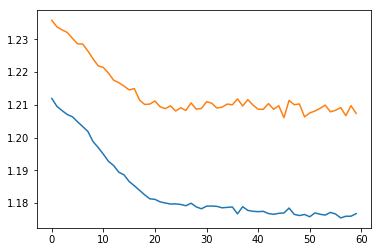

Best training loss = 1.175459
Best validation loss = 1.206062


[1.2060624529736623,
 [2.9873346725396286,
  2.9708720517727203,
  2.9579567317991295,
  3.0325449647720255,
  3.049150329197403,
  3.012709836264592,
  3.0375198634303833,
  3.0287671236820746,
  2.9522746377046145,
  3.0627892290854186,
  3.0248369943042803,
  2.99382208629799,
  2.876909327218591,
  3.019742259819378,
  3.008917900326731,
  3.0282791614557745,
  2.992375299321121,
  3.1925539947198196,
  3.133547164907702,
  2.9929930647243967,
  3.022799774481742,
  3.010006706763438,
  2.9446947114267283,
  2.9291608144731276,
  3.1883619532464715,
  2.983705177441306,
  2.977692053878914,
  2.946025044332269,
  3.0006278660733754,
  3.237855788289501,
  3.1415111375055296,
  2.9990730391929077,
  3.0407895628526505,
  2.994463376737305,
  2.983408956753013,
  3.1819889100024517,
  3.0655473013172463,
  3.008315060771278,
  2.9140214068579735,
  3.0373793617391778,
  2.988596431308765,
  3.0210785636020754,
  3.003168547361086,
  3.054629807771312,
  2.946473852030201,
  2.9453379

In [18]:
main_rbm(training=training, validation=validation, trStats=trStats, vlStats=vlStats, 
             K=5, F=8, epochs=30, gradientLearningRate=0.001, gradientLearningRate_v = 0.0001/10,
             gradientLearningRate_h = 0.0001/10, minibatch_size=10, alpha=0.9, 
             stopping=True, momentum=True, learning_rate_type='time', learning_rate_k=0.5, 
             learning_rate_drop=0.5, learning_rate_epochs_drop=10.0, _lambda = 0.1)

### EPOCH 1 ###
Training loss = 1.209228
Validation loss = 1.233880
### EPOCH 2 ###
Training loss = 1.208409
Validation loss = 1.233206
### EPOCH 3 ###
Training loss = 1.207596
Validation loss = 1.231465
### EPOCH 4 ###
Training loss = 1.206502
Validation loss = 1.231180
### EPOCH 5 ###
Training loss = 1.205642
Validation loss = 1.231739
### EPOCH 6 ###
Training loss = 1.204354
Validation loss = 1.229096
### EPOCH 7 ###
Training loss = 1.202707
Validation loss = 1.227173
### EPOCH 8 ###
Training loss = 1.200873
Validation loss = 1.225475
### EPOCH 9 ###
Training loss = 1.198285
Validation loss = 1.223888
### EPOCH 10 ###
Training loss = 1.195312
Validation loss = 1.222688
### EPOCH 11 ###
Training loss = 1.192032
Validation loss = 1.219930
### EPOCH 12 ###
Training loss = 1.189056
Validation loss = 1.216324
### EPOCH 13 ###
Training loss = 1.186806
Validation loss = 1.213654
### EPOCH 14 ###
Training loss = 1.184304
Validation loss = 1.212609
### EPOCH 15 ###
Training loss = 1.181179
V

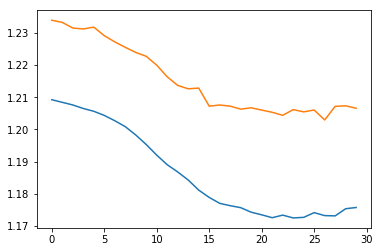

Best training loss = 1.172552
Best validation loss = 1.202946


ValueError: operands could not be broadcast together with shapes (485,) (97,5) 

In [10]:
## Final parameters:
alpha = 0.9
_lambda = 0.1 #tuned
gradientLearningRate = 0.001 #tuned
minibatch_size = 10
F = 8 

W = main_rbm(training=training, validation=validation, trStats=trStats, vlStats=vlStats, 
             K=5, F=best_F, epochs=30, gradientLearningRate=best_lr, gradientLearningRate_v = 0.0001/best_batch,
             gradientLearningRate_h = 0.0001/best_batch, minibatch_size=best_batch, alpha=best_momentum, 
             stopping=True, momentum=True, learning_rate_type='time', learning_rate_k=0.5, 
             learning_rate_drop=0.5, learning_rate_epochs_drop=10.0, _lambda = best_reg)

vis = W[3]
hid = W[4]



In [16]:
predictedRatings = np.array([predictForUser(user, W[2], training,vis,hid) for user in trStats["u_users"]])
np.savetxt("SpateggiChikenChoope+v3.txt", predictedRatings)

In [15]:
def predictForUser(user, W, training,vis_bias,hid_bias, predictType="exp"):
    ### TO IMPLEMENT
    # given a user ID, predicts all movie ratings for the user
    return [predictMovieForUser(movie, user, W, training,vis_bias,hid_bias, predictType=predictType) for movie in lib.getUsefulStats(training)["u_movies"]]

def predictMovieForUser(q, user, W, training,vis_bias,hid_bias, predictType="exp"):
    # movie is movie idx
    # user is user ID
    # type can be "max" or "exp"
    ratingsForUser = lib.getRatingsForUser(user, training)
    v = rbm.getV(ratingsForUser)
    ratingDistribution = rbm.getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], W[q, :, :],vis_bias,hid_bias[q,:])
    if predictType == "max":
        return rbm.predictRatingMax(ratingDistribution)
    elif predictType == "mean":
        return rbm.predictRatingMean(ratingDistribution)
    else:
        return rbm.predictRatingExp(ratingDistribution)

In [ ]:
ratingsForUser1 = lib.getRatingsForUser(0, training)
ratingsForUser1

In [ ]:
W[2][0]

In [23]:
count = 10

In [27]:
count%10 == 0

True

In [ ]:
def predictForUser1(user, W, training,vis_bias,hid_bias, predictType="exp"):
    ### TO IMPLEMENT
    # given a user ID, predicts all movie ratings for the user
    return [predictMovieForUser1(movie, user, W, training,vis_bias,hid_bias, predictType=predictType) for movie in lib.getUsefulStats(training)["u_movies"]]

In [ ]:
predictedRatings = np.array([predictForUser1(user, W[2], training,vis,hid) for user in trStats["u_users"]])